In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from helper_dataset import DatasetHelper
from recommender_recommender_model import RecommenderModel

from helper_transportation import TransportationHelper
from helper_warehouse import WarehouseHelper
from helper_distance import DistanceHelper
from helper_graphs import GraphsHelper

%matplotlib inline

### Prepare data

In [2]:
# Regular Orders
orders_df = DatasetHelper.load_orders()
# orders_df = DatasetHelper.load_orders_100k()
# orders_df = DatasetHelper.load_orders_1m()

users_df = DatasetHelper.load_users()
# users_df = DatasetHelper.load_users_100k()

products_df = DatasetHelper.load_products()
categories_df = DatasetHelper.load_categories()
transportations_df = DatasetHelper.load_transportations()
warehouses_df = DatasetHelper.load_warehouses()

warehouse_product_availability = DatasetHelper.load_warehouse_product_availability()
warehouse_transportation_options = DatasetHelper.load_warehouse_transport_options()

In [3]:
print(f"Length of orders {len(orders_df)}")

Length of orders 10000


In [4]:
# Merge Orders and Products
orders_products_df = pd.merge(orders_df,
                              products_df,
                              left_on='product_id',
                              right_on='id',
                              how='left')

# Drop The id Column
orders_products_df.drop('id', axis=1, inplace=True)

# Rename columns
orders_products_df.rename(columns={'name': 'product_name',
                                   'price_pr_unit_y': 'product_price_pr_unit',
                                   'price_pr_unit_x': 'order_price_pr_unit',
                                   'unit': 'product_unit',
                                   'weight': 'product_weight'}
                          , inplace=True)

orders_products_df.head()

,order_id,order_date,order_time_stamp,user_id,warehouse_id,transportation_id,product_id,order_price_pr_unit,order_quantity,product_name,category_id,product_price_pr_unit,co2,co2per_kg,product_weight,color
0,1,2022-09-30,1.664557e+09,663,3,2,13,319,1,BA 360 balance board,4,319,5.460000,2.7030,2.02,brown
1,2,2022-06-06,1.654491e+09,170,2,2,18,414,2,Berg benchtable,4,414,105.556318,1.6932,62.34,red
2,3,2021-11-24,1.637776e+09,496,10,3,3,834,1,April bench_ C,4,834,69.229940,2.1560,32.11,blue
3,4,2022-11-20,1.668909e+09,75,4,1,21,998,2,BMA Axia 2.2,4,998,77.300000,3.9239,19.70,brown
4,5,2022-12-19,1.671488e+09,459,6,2,32,478,0,Cabinet_ MFC_ w/sliding doors_ W120_ 1 level,5,478,68.486030,1.6435,41.67,white


In [5]:
# Merge Orders and Categories
orders_products_df = pd.merge(orders_products_df,
                              categories_df,
                              left_on='category_id',
                              right_on='id',
                              how='left')

# Drop Unit, id and CategoryId
orders_products_df.drop(['unit',
                         'id',
                         'category_id']
                        , axis=1,
                        inplace=True)

# Rename columns
orders_products_df.rename(columns={'name': 'category_name'}, inplace=True)

orders_products_df.head()

,order_id,order_date,order_time_stamp,user_id,warehouse_id,transportation_id,product_id,order_price_pr_unit,order_quantity,product_name,product_price_pr_unit,co2,co2per_kg,product_weight,color,category_name
0,1,2022-09-30,1.664557e+09,663,3,2,13,319,1,BA 360 balance board,319,5.460000,2.7030,2.02,brown,Seating furniture
1,2,2022-06-06,1.654491e+09,170,2,2,18,414,2,Berg benchtable,414,105.556318,1.6932,62.34,red,Seating furniture
2,3,2021-11-24,1.637776e+09,496,10,3,3,834,1,April bench_ C,834,69.229940,2.1560,32.11,blue,Seating furniture
3,4,2022-11-20,1.668909e+09,75,4,1,21,998,2,BMA Axia 2.2,998,77.300000,3.9239,19.70,brown,Seating furniture
4,5,2022-12-19,1.671488e+09,459,6,2,32,478,0,Cabinet_ MFC_ w/sliding doors_ W120_ 1 level,478,68.486030,1.6435,41.67,white,Cabinet


In [6]:
products_df.head()

,id,name,category_id,price_pr_unit,co2,co2per_kg,weight,color
0,1,Ami Sofa,4,592,249.102668,4.1517,60.00,green
1,2,Ami Stol,4,455,139.438947,4.6480,30.00,yellow
2,3,April bench_ C,4,834,69.229940,2.1560,32.11,blue
3,4,April Go bench,4,800,36.286787,2.4063,15.08,blue
4,5,April Go chair wood,4,928,29.649980,2.6216,11.31,yellow


In [7]:
df_products = products_df[['id', 'name']]

# Rename Name Column
df_products.rename(columns={'name': 'product_name'}, inplace=True)
df_products.rename(columns={'id': 'product_id'}, inplace=True)

df_products.head()

C:\Users\danie\AppData\Local\Temp\ipykernel_47704\2431536300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products.rename(columns={'name': 'product_name'}, inplace=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_47704\2431536300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products.rename(columns={'id': 'product_id'}, inplace=True)


,product_id,product_name
0,1,Ami Sofa
1,2,Ami Stol
2,3,April bench_ C
3,4,April Go bench
4,5,April Go chair wood


In [8]:
# Create DataFrame for training
df_orders = orders_products_df[[
    'user_id',
    'product_name',
    'order_time_stamp',
    'color',
    'category_name',
    "order_quantity",
]]

df_orders.head()

,user_id,product_name,order_time_stamp,color,category_name,order_quantity
0,663,BA 360 balance board,1.664557e+09,brown,Seating furniture,1
1,170,Berg benchtable,1.654491e+09,red,Seating furniture,2
2,496,April bench_ C,1.637776e+09,blue,Seating furniture,1
3,75,BMA Axia 2.2,1.668909e+09,brown,Seating furniture,2
4,459,Cabinet_ MFC_ w/sliding doors_ W120_ 1 level,1.671488e+09,white,Cabinet,0


In [9]:
# Create DataSets from DataFrames
orders = tf.data.Dataset.from_tensor_slices(dict(df_orders))
products = tf.data.Dataset.from_tensor_slices(dict(df_products))

In [10]:
# Map the data for the model
orders = orders.map(lambda x: {
    "product_name": x["product_name"],
    "user_id": x["user_id"],
    "order_time_stamp": x["order_time_stamp"],
    "color": x["color"],
    "category_name": x["category_name"],
    "order_quantity": x["order_quantity"],
})
products = products.map(lambda x: x["product_name"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Concatenate the timestamps
timestamps = np.concatenate(list(orders.map(lambda x: x["order_time_stamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

# Create unique values for each feature.
unique_product_names = np.unique(np.concatenate(list(products.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(orders.batch(1000).map(lambda x: x["user_id"]))))
unique_colors = np.unique(np.concatenate(list(orders.batch(1000).map(lambda x: x["color"]))))
unique_category_names = np.unique(np.concatenate(list(orders.batch(1000).map(lambda x: x["category_name"]))))

In [12]:
orders

<MapDataset element_spec={'product_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'order_time_stamp': TensorSpec(shape=(), dtype=tf.float64, name=None), 'color': TensorSpec(shape=(), dtype=tf.string, name=None), 'category_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'order_quantity': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [13]:
list(orders.as_numpy_iterator())[0]

{'product_name': b'BA 360 balance board',
 'user_id': 663,
 'order_time_stamp': 1664557115.0,
 'color': b'brown',
 'category_name': b'Seating furniture',
 'order_quantity': 1}

In [14]:
products

<MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [15]:
list(products.as_numpy_iterator())[0]

b'Ami Sofa'

### Train data

In [16]:
# Project settings
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2
SEED = 42
NUMBER_OF_EPOCHS = 100

In [17]:
tf.random.set_seed(SEED)
DATA_SIZE = len(df_orders)

shuffled_data = orders.shuffle(DATA_SIZE, seed=SEED, reshuffle_each_iteration=False)

train = shuffled_data.take(int(DATA_SIZE * TRAIN_SIZE))
test = shuffled_data.skip(int(DATA_SIZE * TRAIN_SIZE)).take(int(DATA_SIZE * TEST_SIZE))

cached_train = train.shuffle(DATA_SIZE).batch(4096).cache()
cached_test = test.batch(4096).cache()

In [18]:
# Length of training and test data.
print(f"Length of training data: {len(train)}")
print(f"Length of test data: {len(test)}")

Length of training data: 8000
Length of test data: 2000


In [19]:
# 1 layer model
model = RecommenderModel([32],
                         rating_weight = 0.5,
                         retrieval_weight = 0.5,
                         unique_product_names = unique_product_names,
                         products = products,
                         unique_user_ids = unique_user_ids,
                         timestamp_buckets = timestamp_buckets,
                         timestamps = timestamps,
                         unique_colors = unique_colors,
                         unique_category_names = unique_category_names
                         )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=NUMBER_OF_EPOCHS,
    verbose=0)

In [20]:
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 1.00.


In [21]:
# 2 layer model
model_two_layer = RecommenderModel([64, 32],
                                   rating_weight=0.5,
                                   retrieval_weight=0.5,
                                   unique_product_names = unique_product_names,
                                   products = products,
                                   unique_user_ids = unique_user_ids,
                                   timestamp_buckets = timestamp_buckets,
                                   timestamps = timestamps,
                                   unique_colors = unique_colors,
                                   unique_category_names = unique_category_names
                                   )
model_two_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model_two_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=NUMBER_OF_EPOCHS,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.98.


In [22]:
# Train the model with 3 layers
model_three_layer = RecommenderModel([128, 64, 32],
                                     rating_weight=0.5,
                                     retrieval_weight=0.5,
                                     unique_product_names = unique_product_names,
                                     products = products,
                                     unique_user_ids = unique_user_ids,
                                     timestamp_buckets = timestamp_buckets,
                                     timestamps = timestamps,
                                     unique_colors = unique_colors,
                                     unique_category_names = unique_category_names
                                     )
model_three_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model_three_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=NUMBER_OF_EPOCHS,
    verbose=0)
accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.97.


### Helpers

In [23]:
def plot_model_statistics(models,
                          labels,
                          metric,
                          title,
                          x_label,
                          y_label):
    """
    Plot the model statistics
    :param models: Models to plot
    :param labels: Labels for the models
    :param metric: Metric to plot
    :param title: Title of the plot
    :param x_label: X-axis label
    :param y_label: Y-axis label
    :return: None
    """
    num_validation_runs = len(models[0].history[metric])
    epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

    for mod, label in zip(models, labels):
        plt.plot(epochs, mod.history[metric], label=label)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

### Evaluate & Statistics

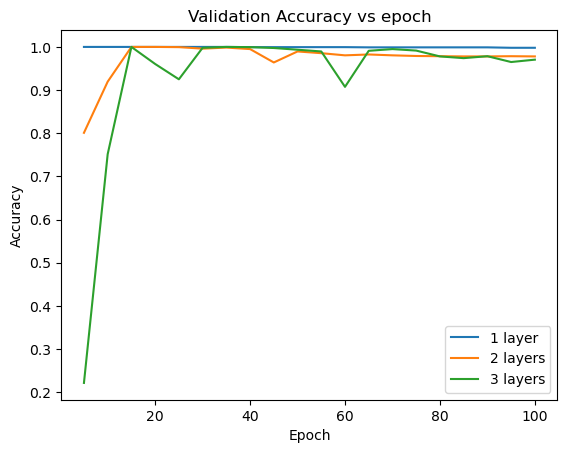

In [24]:
plot_model_statistics(
    [one_layer_history, two_layer_history, three_layer_history],
    ["1 layer", "2 layers", "3 layers"],
    "val_factorized_top_k/top_100_categorical_accuracy",
    "Validation Accuracy vs epoch",
    "Epoch",
    "Accuracy",
)

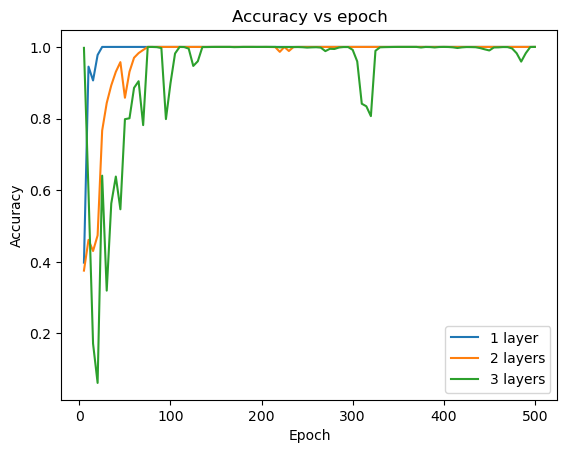

In [25]:
plot_model_statistics(
    [one_layer_history, two_layer_history, three_layer_history],
    ["1 layer", "2 layers", "3 layers"],
    "factorized_top_k/top_100_categorical_accuracy",
    "Accuracy vs epoch",
    "Epoch",
    "Accuracy",
)

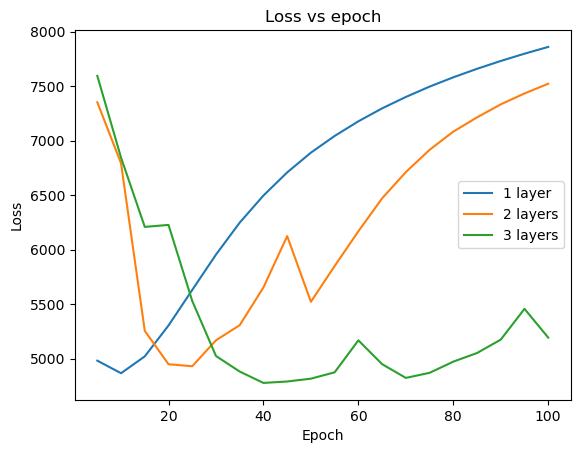

In [26]:
plot_model_statistics(
    [one_layer_history, two_layer_history, three_layer_history],
    ["1 layer", "2 layers", "3 layers"],
    "val_loss",
    "Loss vs epoch",
    "Epoch",
    "Loss",
)

In [27]:
model_three_layer.build([])
model_three_layer.build([])
model_three_layer.summary()

Model: "recommender_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 query_model_2 (QueryModel)  multiple                  739715    
                                                                 
 candidate_model_2 (Candidat  multiple                 346368    
 eModel)                                                         
                                                                 
 sequential_32 (Sequential)  (None, 1)                 49665     
                                                                 
 ranking_2 (Ranking)         multiple                  0         
                                                                 
 retrieval_2 (Retrieval)     multiple                  1         
                                                                 
Total params: 1,135,749
Trainable params: 1,135,745
Non-trainable params: 4
_____________________________________

In [28]:
model_three_layer.query_model.summary()

Model: "query_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_model_2 (UserModel)    multiple                  704547    
                                                                 
 sequential_28 (Sequential)  (None, 32)                35168     
                                                                 
Total params: 739,715
Trainable params: 739,712
Non-trainable params: 3
_________________________________________________________________


In [29]:
model_three_layer.candidate_model.summary()

Model: "candidate_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 product_model_2 (ProductMod  multiple                 327712    
 el)                                                             
                                                                 
 sequential_31 (Sequential)  (None, 32)                18656     
                                                                 
Total params: 346,368
Trainable params: 346,368
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_three_layer.query_model.embedding_model.summary()

Model: "user_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 32)                32032     
                                                                 
 sequential_23 (Sequential)  (None, 32)                32032     
                                                                 
 normalization_2 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_24 (Sequential)  (None, 32)                352       
                                                                 
 text_vectorization_6 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 sequential_25 (Sequential)  (None, 32)               

In [31]:
model_three_layer.candidate_model.embedding_model.summary()

Model: "product_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 32)                7712      
                                                                 
 text_vectorization_8 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 sequential_30 (Sequential)  (None, 32)                320000    
                                                                 
Total params: 327,712
Trainable params: 327,712
Non-trainable params: 0
_________________________________________________________________


In [32]:
def print_model_statistics_on_train_test(data_model):
    """
    Print the model statistics on train and test data
    :param data_model: Model to evaluate
    :return:
    """
    train_acc = data_model.evaluate(
        cached_train, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']
    test_acc = data_model.evaluate(
        cached_test, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']

    print(f'Top-100 accuracy (train): {train_acc:.2f}')
    print(f'Top-100 accuracy (test): {test_acc:.2f}')

In [33]:
print_model_statistics_on_train_test(model_three_layer)

1/1 [==============================] - 0s 88ms/step - root_mean_squared_error: 1.1356 - factorized_top_k/top_1_categorical_accuracy: 0.3275 - factorized_top_k/top_5_categorical_accuracy: 0.9270 - factorized_top_k/top_10_categorical_accuracy: 0.9440 - factorized_top_k/top_50_categorical_accuracy: 0.9620 - factorized_top_k/top_100_categorical_accuracy: 0.9705 - loss: 5192.3813 - regularization_loss: 0.0000e+00 - total_loss: 5192.3813
Top-100 accuracy (train): 1.00
Top-100 accuracy (test): 0.97


In [34]:
model_three_layer.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 85ms/step - root_mean_squared_error: 1.1356 - factorized_top_k/top_1_categorical_accuracy: 0.3275 - factorized_top_k/top_5_categorical_accuracy: 0.9270 - factorized_top_k/top_10_categorical_accuracy: 0.9440 - factorized_top_k/top_50_categorical_accuracy: 0.9620 - factorized_top_k/top_100_categorical_accuracy: 0.9705 - loss: 5192.3813 - regularization_loss: 0.0000e+00 - total_loss: 5192.3813


{'root_mean_squared_error': 1.1355501413345337,
 'factorized_top_k/top_1_categorical_accuracy': 0.32749998569488525,
 'factorized_top_k/top_5_categorical_accuracy': 0.9269999861717224,
 'factorized_top_k/top_10_categorical_accuracy': 0.9440000057220459,
 'factorized_top_k/top_50_categorical_accuracy': 0.9620000123977661,
 'factorized_top_k/top_100_categorical_accuracy': 0.9704999923706055,
 'loss': 5192.38134765625,
 'regularization_loss': 0,
 'total_loss': 5192.38134765625}

In [35]:
model_three_layer.evaluate(cached_train, return_dict=True)

2/2 [==============================] - 0s 112ms/step - root_mean_squared_error: 1.1229 - factorized_top_k/top_1_categorical_accuracy: 0.5250 - factorized_top_k/top_5_categorical_accuracy: 0.9896 - factorized_top_k/top_10_categorical_accuracy: 0.9936 - factorized_top_k/top_50_categorical_accuracy: 0.9995 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9927.9990 - regularization_loss: 0.0000e+00 - total_loss: 9927.9990


{'root_mean_squared_error': 1.1229077577590942,
 'factorized_top_k/top_1_categorical_accuracy': 0.5249999761581421,
 'factorized_top_k/top_5_categorical_accuracy': 0.9896249771118164,
 'factorized_top_k/top_10_categorical_accuracy': 0.9936249852180481,
 'factorized_top_k/top_50_categorical_accuracy': 0.9994999766349792,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 9732.8759765625,
 'regularization_loss': 0,
 'total_loss': 9732.8759765625}

# Get Recommendations for products

In [36]:
def print_recommendations(list_product_names, list_product_scores):
    """
    Print the recommendations to the console
    :param list_product_names: Product names to print
    :param list_product_scores: Product scores to print
    :return: None
    """
    if type(list_product_names) == str:
        print(f"{list_product_names}: {list_product_scores}")
    elif len(list_product_names) == 1:
        print(f"{list_product_names[0]}: {list_product_scores[0]}")
    else:
        for i in range(len(list_product_names)):
            print(f"{list_product_names[i]}: {list_product_scores[i]}")

In [37]:
def get_recommendation(data_user_id, data_order_time_stamp, data_color, data_category_name, data_predict_product):
    """
    Get the recommendation for a product
    :param data_user_id: User ID
    :param data_order_time_stamp: Order time stamp
    :param data_color: Color
    :param data_category_name: Category name
    :param data_predict_product: Product to predict
    :return: Product name and score
    """
    query = model.query_model.predict({
        "user_id": np.array([data_user_id]),
        "order_time_stamp": np.array([data_order_time_stamp]),
        "color": np.array([data_color]),
        "category_name": np.array([data_category_name]),
    }, verbose=0)

    predicted_product = model.candidate_model.predict([data_predict_product], verbose=0)
    print(f'Prediction for product: {data_predict_product}')
    print(f'For user: {data_user_id}, order_time_stamp: {data_order_time_stamp}, color: {data_color}, category_name: {data_category_name}')

    product_score = np.matmul(query, np.transpose(predicted_product))

    return data_predict_product, product_score[0][0]


In [38]:
recommendation = get_recommendation(25, 1, "red", "Seating furniture", "Camp chair - low back")
print_recommendations(recommendation[0], recommendation[1])

Prediction for product: Camp chair - low back
For user: 25, order_time_stamp: 1, color: red, category_name: Seating furniture
Camp chair - low back: 21.75335693359375


In [61]:
recommendation = get_recommendation(25, 100, "blue", "Table", "Knekk table")
print_recommendations(recommendation[0], recommendation[1])

Prediction for product: Knekk table
For user: 25, order_time_stamp: 100, color: blue, category_name: Table
Knekk table: -15.916362762451172


In [62]:
recommendation = get_recommendation(25, 1000, "green", "Seating furniture", "HÅG Capisco 8106")
print_recommendations(recommendation[0], recommendation[1])

Prediction for product: HÅG Capisco 8106
For user: 25, order_time_stamp: 1000, color: green, category_name: Seating furniture
HÅG Capisco 8106: 1.438442349433899


In [41]:
def recommend_top_5_detailed(data_user_id, data_order_time_stamp, data_color, data_category_name):
    """
    Recommend the top 5 products for a user
    :param data_user_id: User ID
    :param data_order_time_stamp: Order time stamp
    :param data_color: Color
    :param data_category_name: Category name
    :return: Product name and score
    """
    query = model.query_model.predict({
        "user_id": np.array([data_user_id]),
        "order_time_stamp": np.array([data_order_time_stamp]),
        "color": np.array([data_color]),
        "category_name": np.array([data_category_name]),
    }, verbose=0)

    predicted_product = model.candidate_model.predict([unique_product_names], verbose=0)

    # Sort the scores from the highest to the lowest.
    scores = np.matmul(query, np.transpose(predicted_product))
    sorted_indices = np.argsort(scores)[0][::-1]

    # Get the corresponding product name and print them out.
    print(f'Recommendations for user: {data_user_id}, order_time_stamp: {data_order_time_stamp}, color: {data_color}, category_name: {data_category_name}')

    return unique_product_names[sorted_indices][:5], scores[0][sorted_indices][:5]

In [42]:
recommendations = recommend_top_5_detailed(21, 1, "red", "Seating furniture")
print_recommendations(recommendations[0], recommendations[1])

Recommendations for user: 21, order_time_stamp: 1, color: red, category_name: Seating furniture
b'Backapp 360': 88.41954040527344
b'Backapp Wheels': 69.6184310913086
b'Berg benchtable': 64.48860168457031
b'Bo Dining table 180 x 90 cm': 41.48746109008789
b'Backapp Hipp': 34.73447799682617


In [43]:
recommendations = recommend_top_5_detailed(21, 1, "blue", "Seating furniture")
print_recommendations(recommendations[0], recommendations[1])

Recommendations for user: 21, order_time_stamp: 1, color: blue, category_name: Seating furniture
b'Backapp 360': 84.89990234375
b'Backapp Wheels': 69.20880126953125
b'Berg benchtable': 45.30912780761719
b'Camp chair low back': 37.943511962890625
b'Backapp Hipp': 36.6735954284668


# Helper methods for Products

In [44]:
def get_product_from_name(df, data_product_name):
    """
    Get a product from a name
    :param df: Dataframe to search in
    :param data_product_name: Product name to search for
    :return: Product
    """
    return df[df["name"] == data_product_name]

In [65]:
def print_summary_of_closest_product_to_user(product_user, product):
    """
    Print the summary of the closest product to a user
    :param product_user: Product user dataframe
    :param product: Product dataframe
    :return: None
    """
    product_id = product["id"].values[0]
    warehouse = WarehouseHelper.get_5_closest_warehouses(warehouses_df,
                                                         warehouse_product_availability,
                                                         product_user,
                                                         product_id)

    warehouse_trans_cost = TransportationHelper.calculate_transportation_for_closest(warehouses_df,
                                                                                           transportations_df,
                                                                                           warehouse,
                                                                                           product_user)

    print("To send product {}-{} to user {}-{} the following 5 warehouses are the closest:".format(product_id,
                                                                                                   product["name"].values[0],
                                                                                                   product_user['id'].values[0],
                                                                                                   product_user['name'].values[0]))
    for w in range(len(warehouse_trans_cost)):
        warehouse_id = list(warehouse_trans_cost.keys())[w]
        warehouse_name = warehouses_df[warehouses_df["id"] == warehouse_id]["name"].values[0]
        distance = warehouse.get(warehouse_id)
        print("\tWarehouse Id {}-{}".format(warehouse_id, warehouse_name))
        print("\t-Distance to user is {} km".format(distance))

        for l in range(3):
            print('\t\tTransportation cost for {} is {} kg and categorized as {}'.format(warehouse_trans_cost[list(warehouse_trans_cost.keys())[w]][l],
                                                                                         warehouse_trans_cost[list(warehouse_trans_cost.keys())[w]][l][0],
                                                                                         warehouse_trans_cost[list(warehouse_trans_cost.keys())[w]][l][1]))

In [46]:
def print_statistics_from_warehouse_to_user(param_warehouse, param_user, param_product):
    """
    Print the statistics from a warehouse to a user
    :param param_warehouse: Warehouse dataframe
    :param param_user: User dataframe
    :param param_product: Product dataframe
    :return: None
    """
    warehouse_trans_cost = TransportationHelper.calculate_transportation_cost_for_location(transportations_df,
                                                                                           param_warehouse["latitude"],
                                                                                           param_warehouse["longitude"],
                                                                                           param_user["latitude"].values[0],
                                                                                           param_user["longitude"].values[0])

    warehouse_id = param_warehouse["id"].values[0]
    warehouse_name = param_warehouse["name"].values[0]

    distance = DistanceHelper.driving_distance_between_coordinates(param_user['latitude'],
                                                                           param_user['longitude'],
                                                                           param_warehouse['latitude'],
                                                                           param_warehouse['longitude']) / 1000

    print("To send the product {}-{}, to user {}-{}, from warehouse {}-{}:".format(param_product["id"].values[0],
                                                                             param_product["name"].values[0],
                                                                             param_user['id'].values[0],
                                                                             param_user['name'].values[0],
                                                                             warehouse_id,
                                                                             warehouse_name))

    print("The driving distance is {} km".format(distance))
    print("")
    print("The available transportation options with their emissions and environmental friendliness for the delivery are:")
    for w in range(len(warehouse_trans_cost)):
        print(warehouse_trans_cost[w][0])
        print(f"\tEmissions: {warehouse_trans_cost[w][1][0]}")
        print(f"\tImpact level: {warehouse_trans_cost[w][1][1]}")

### Example 1

Using product name as first parameter, then picking the second-closest warehouse to the user.

In [47]:
recommendation_user_id = 443
product_name = "Camp chair - low back"

recommendation_product = get_product_from_name(products_df, product_name)

In [48]:
recommendation_user = users_df[users_df["id"] == recommendation_user_id]
print_summary_of_closest_product_to_user(recommendation_user, recommendation_product)

{14: 13.545, 5: 149.308, 15: 168.043, 2: 185.289, 4: 234.184}
To send product 35-Camp chair - low back to user 443-Jesse Price the following 5 warehouses are the closest:
	Warehouse Id 14-Warehouse Røros
	-Distance to user is 13.545 km
		Transportation cost for ('Light Duty GAS', (36.7435215, 'Very low')) is Light Duty GAS kg and categorized as (36.7435215, 'Very low')
		Transportation cost for ('Light Duty DSL', (37.1769615, 'Very low')) is Light Duty DSL kg and categorized as (37.1769615, 'Very low')
		Transportation cost for ('Heavy Duty DSL', (1.213632, 'Very low')) is Heavy Duty DSL kg and categorized as (1.213632, 'Very low')
	Warehouse Id 5-Warehouse Trondheim
	-Distance to user is 149.308 km
		Transportation cost for ('Light Duty GAS', (405.02781159999995, 'Very low')) is Light Duty GAS kg and categorized as (405.02781159999995, 'Very low')
		Transportation cost for ('Light Duty DSL', (409.8056676, 'Very low')) is Light Duty DSL kg and categorized as (409.8056676, 'Very low')
	

In [49]:
chosen_warehouse_id = 5
chosen_warehouse = warehouses_df[warehouses_df["id"] == chosen_warehouse_id]

In [50]:
print_statistics_from_warehouse_to_user(chosen_warehouse, recommendation_user, recommendation_product)

To send the product 35-Camp chair - low back, to user 443-Jesse Price, from warehouse 5-Warehouse Trondheim:
The driving distance is 149.308 km

The available transportation options with their emissions and environmental friendliness for the delivery are:
Light Duty GAS
	Emissions: 405.68699769999995
	Impact level: Very low
Light Duty DSL
	Emissions: 410.47262969999997
	Impact level: Very low
Heavy Duty DSL
	Emissions: 13.399769599999999
	Impact level: Very low


In [51]:
GraphsHelper.plot_driving_distance(chosen_warehouse['latitude'].values[0],
                                   chosen_warehouse['longitude'].values[0],
                                   chosen_warehouse['name'].values[0],
                                   recommendation_user['latitude'].values[0],
                                   recommendation_user['longitude'].values[0],
                                   recommendation_user['name'].values[0])

### Example 2

Using product name as first parameter, then picking the farthest warehouse to the user.

In [66]:
recommendation_user_id = 84
product_name = "Cabinet_ MFC_ w/sliding doors_ W80_ 1 level"

recommendation_product = get_product_from_name(products_df, product_name)

recommendation_user = users_df[users_df["id"] == recommendation_user_id]
print_summary_of_closest_product_to_user(recommendation_user, recommendation_product)

To send product 34-Cabinet_ MFC_ w/sliding doors_ W80_ 1 level to user 84-Brooke Duran the following 5 warehouses are the closest:
	Warehouse Id 9-Warehouse Kristiansand
	-Distance to user is 6.077 km
		Transportation cost for ('Light Duty GAS', (16.4850779, 'Very low')) is Light Duty GAS kg and categorized as (16.4850779, 'Very low')
		Transportation cost for ('Light Duty DSL', (16.6795419, 'Very low')) is Light Duty DSL kg and categorized as (16.6795419, 'Very low')
		Transportation cost for ('Heavy Duty DSL', (0.5444992, 'Very low')) is Heavy Duty DSL kg and categorized as (0.5444992, 'Very low')
	Warehouse Id 16-Warehouse Larvik
	-Distance to user is 192.711 km
		Transportation cost for ('Light Duty GAS', (522.7671297, 'Very low')) is Light Duty GAS kg and categorized as (522.7671297, 'Very low')
		Transportation cost for ('Light Duty DSL', (528.9338817, 'Very low')) is Light Duty DSL kg and categorized as (528.9338817, 'Very low')
		Transportation cost for ('Heavy Duty DSL', (17.2

In [69]:
chosen_warehouse_id = 12
chosen_warehouse = warehouses_df[warehouses_df["id"] == chosen_warehouse_id]

print_statistics_from_warehouse_to_user(chosen_warehouse, recommendation_user, recommendation_product)

To send the product 34-Cabinet_ MFC_ w/sliding doors_ W80_ 1 level, to user 84-Brooke Duran, from warehouse 12-Warehouse Fredrikstad:
The driving distance is 292.946 km

The available transportation options with their emissions and environmental friendliness for the delivery are:
Light Duty GAS
	Emissions: 792.8679559999999
	Impact level: Low
Light Duty DSL
	Emissions: 802.2209159999999
	Impact level: Low
Heavy Duty DSL
	Emissions: 26.188287999999996
	Impact level: Low


In [70]:
GraphsHelper.plot_driving_distance(chosen_warehouse['latitude'].values[0],
                                   chosen_warehouse['longitude'].values[0],
                                   chosen_warehouse['name'].values[0],
                                   recommendation_user['latitude'].values[0],
                                   recommendation_user['longitude'].values[0],
                                   recommendation_user['name'].values[0])

### Example 3

Using category name as first parameter, then selecting the product which is of most interest to the user, then picking the middle warehouse to the user.

In [73]:
recommendation_user_id = 767
category_name = "Plate furniture"

recommendations = recommend_top_5_detailed(recommendation_user_id, 1, "blue", category_name)
print_recommendations(recommendations[0], recommendations[1])

Recommendations for user: 767, order_time_stamp: 1, color: blue, category_name: Plate furniture
b'Backapp 360': 66.11698150634766
b'Backapp Wheels': 45.651023864746094
b'Bordplate 140x80cm med h\xc3\xb8ytrykkslaminat': 33.178165435791016
b'Berg benchtable': 32.451358795166016
b'Cabinet_ MFC_ w/sliding doors_ W80_ 1 level': 26.653528213500977


In [75]:
product_name = "Bordplate 140x80cm med høytrykkslaminat"

recommendation_product = get_product_from_name(products_df, product_name)

recommendation_user = users_df[users_df["id"] == recommendation_user_id]
print_summary_of_closest_product_to_user(recommendation_user, recommendation_product)

To send product 27-Bordplate 140x80cm med høytrykkslaminat to user 767-Roger Warner the following 5 warehouses are the closest:
	Warehouse Id 18-Warehouse Haugesund
	-Distance to user is 8.915 km
		Transportation cost for ('Light Duty GAS', (24.183720499999996, 'Very low')) is Light Duty GAS kg and categorized as (24.183720499999996, 'Very low')
		Transportation cost for ('Light Duty DSL', (24.469000499999996, 'Very low')) is Light Duty DSL kg and categorized as (24.469000499999996, 'Very low')
		Transportation cost for ('Heavy Duty DSL', (0.7987839999999999, 'Very low')) is Heavy Duty DSL kg and categorized as (0.7987839999999999, 'Very low')
	Warehouse Id 11-Warehouse Stavanger
	-Distance to user is 92.904 km
		Transportation cost for ('Light Duty GAS', (252.02068079999998, 'Very low')) is Light Duty GAS kg and categorized as (252.02068079999998, 'Very low')
		Transportation cost for ('Light Duty DSL', (254.99360879999998, 'Very low')) is Light Duty DSL kg and categorized as (254.993

In [76]:
chosen_warehouse_id = 8
chosen_warehouse = warehouses_df[warehouses_df["id"] == chosen_warehouse_id]

print_statistics_from_warehouse_to_user(chosen_warehouse, recommendation_user, recommendation_product)

To send the product 27-Bordplate 140x80cm med høytrykkslaminat, to user 767-Roger Warner, from warehouse 8-Warehouse Bergen:
The driving distance is 136.274 km

The available transportation options with their emissions and environmental friendliness for the delivery are:
Light Duty GAS
	Emissions: 368.5392839
	Impact level: Very low
Light Duty DSL
	Emissions: 372.8867079
	Impact level: Very low
Heavy Duty DSL
	Emissions: 12.1727872
	Impact level: Very low


In [77]:
GraphsHelper.plot_driving_distance(chosen_warehouse['latitude'].values[0],
                                   chosen_warehouse['longitude'].values[0],
                                   chosen_warehouse['name'].values[0],
                                   recommendation_user['latitude'].values[0],
                                   recommendation_user['longitude'].values[0],
                                   recommendation_user['name'].values[0])